In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from __future__ import annotations
from pathlib import Path
import re
from scipy.optimize import curve_fit

In [2]:
# with open("data/Zscan.UXD", "r") as f:
#     for i in range(40):
#         print(f.readline().rstrip())


In [3]:
# ----------------------------
# 1) Your existing parser (or keep using bruker_text_to_df)
# ----------------------------

_numline_re = re.compile(r"^\s*[+-]?(?:\d+\.?\d*|\.\d+)(?:[eE][+-]?\d+)?")

def bruker_text_to_df(path: str, colnames=("x", "counts")):
    """
    Parses Bruker UXD (and XCH text exports) into (meta, df).
    - meta: dict with _KEY=VALUE lines
    - df: numeric block with columns [x, counts]
    """
    meta = {}
    data = []

    with open(path, "r", errors="ignore") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith(";"):
                continue

            if line.startswith("_") and "=" in line:
                k, v = line.split("=", 1)
                meta[k.strip()] = v.strip().strip("'")
                continue

            if _numline_re.match(line):
                parts = line.split()
                if len(parts) >= 2:
                    try:
                        data.append((float(parts[0]), float(parts[1])))
                    except ValueError:
                        pass

    df = pd.DataFrame(data, columns=list(colnames))
    return meta, df


# ----------------------------
# 2) One clean loader for *all* UXD files in data/
# ----------------------------

def load_all_uxd(
    folder: str | Path = "data",
    pattern: str = "*.UXD",
    *,
    add_scan_name_col: bool = True,
    add_meta_cols: bool = True,
) -> tuple[pd.DataFrame, dict[str, dict]]:
    """
    Loads all UXD files under folder into:
      - one concatenated DataFrame (tagged by scan_name)
      - a metadata dict keyed by scan_name

    add_meta_cols: if True, add a few useful metadata fields into the dataframe
                  (same for every row within a scan).
    """
    folder = Path(folder)
    paths = sorted(folder.glob(pattern))

    dfs = []
    metas: dict[str, dict] = {}

    # choose a small, stable set of metadata keys to copy into df (optional)
    meta_keys = ["_WL1", "_DATEMEASURED", "_TYPE", "_STEPSIZE", "_STEPTIME"]

    for p in paths:
        meta, df = bruker_text_to_df(str(p))

        scan_name = p.stem  # e.g. "Zscan", "omega_2theta", "rocking_scan_1", ...
        metas[scan_name] = meta

        df = df.copy()
        if add_scan_name_col:
            df["scan_name"] = scan_name

        if add_meta_cols:
            for k in meta_keys:
                if k in meta:
                    df[k.lstrip("_").lower()] = meta[k]

        dfs.append(df)

    all_df = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()
    return all_df, metas


# ----------------------------
# 3) Convenience helpers for your specific file set
# ----------------------------

def select_scan(all_df: pd.DataFrame, name: str) -> pd.DataFrame:
    """Return a single scan by scan_name."""
    return all_df.loc[all_df["scan_name"].eq(name)].copy()

def quick_index(all_df: pd.DataFrame) -> pd.DataFrame:
    """A quick overview table: rows per scan + key metadata."""
    cols = [c for c in ["scan_name", "wl1", "datemeasured", "type", "stepsize", "steptime"] if c in all_df.columns]
    out = (
        all_df[cols]
        .drop_duplicates()
        .merge(all_df.groupby("scan_name").size().rename("n_points"), on="scan_name")
        .sort_values("scan_name")
        .reset_index(drop=True)
    )
    return out


# ----------------------------
# 4) Use it
# ----------------------------

all_scans, metas = load_all_uxd("data")

# overview
overview = quick_index(all_scans)
display(overview)

# grab particular scans cleanly
df_xscan      = select_scan(all_scans, "Xscan")
df_zscan      = select_scan(all_scans, "Zscan")
df_zscan2     = select_scan(all_scans, "Zscan_2")
df_det        = select_scan(all_scans, "Detektorscsan")
df_refl       = select_scan(all_scans, "omega_2theta")
df_refl_bg    = select_scan(all_scans, "omega_2theta_background")
df_rock1      = select_scan(all_scans, "rocking_scan_1")

# access metadata if needed
metas["omega_2theta"].get("_WL1"), metas["omega_2theta"].get("_DATEMEASURED")


,scan_name,wl1,datemeasured,stepsize,steptime,n_points
0,Detektorscsan,1.540600,15-Dec-2025 11:20:51,0.020000,0.999980,51
1,Xscan,1.540600,15-Dec-2025 11:25:15,1.000000,1.000000,41
2,Zscan,1.540600,15-Dec-2025 11:23:15,0.040000,1.000000,51
3,Zscan_2,1.540600,15-Dec-2025 11:43:52,0.020000,1.000000,51
4,Zscan_3,1.540600,15-Dec-2025 11:50:57,0.020000,1.000000,51
5,omega_2theta,1.540600,15-Dec-2025 11:58:14,0.005000,5.000660,301
6,omega_2theta_background,1.540600,15-Dec-2025 12:25:11,0.005000,5.000660,301
7,rocking_scan_1,1.540600,15-Dec-2025 11:41:53,0.040000,1.000000,26
8,rocking_scan_2,1.540600,15-Dec-2025 11:46:11,0.050000,1.000000,7
9,rocking_scan_3,1.540600,15-Dec-2025 11:54:27,0.005000,1.000000,61


('1.540600', '15-Dec-2025 11:58:14')

In [4]:
def needs_log_scale(name):
    return "omega" in name.lower() or "2theta" in name.lower()

def plot_all_scans_tiled(all_scans, xcol="x", ycol="counts", max_cols=3):
    scan_names = sorted(all_scans["scan_name"].unique())
    n = len(scan_names)

    ncols = min(max_cols, n)
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(
        nrows, ncols,
        figsize=(6.5 * ncols, 3.5 * nrows),
        sharex=False,
        sharey=False
    )

    # Make axes iterable even if nrows or ncols == 1
    axes = axes.flatten() if n > 1 else [axes]

    for ax, name in zip(axes, scan_names):
        if needs_log_scale(name):
            ax.set_yscale("log")

        df = select_scan(all_scans, name).sort_values(xcol)

        ax.plot(df[xcol], df[ycol], ".-")
        ax.set_title(name)
        ax.set_xlabel(xcol)
        ax.set_ylabel(ycol)

    # Hide unused axes
    for ax in axes[len(scan_names):]:
        ax.axis("off")

    fig.tight_layout()
    return fig


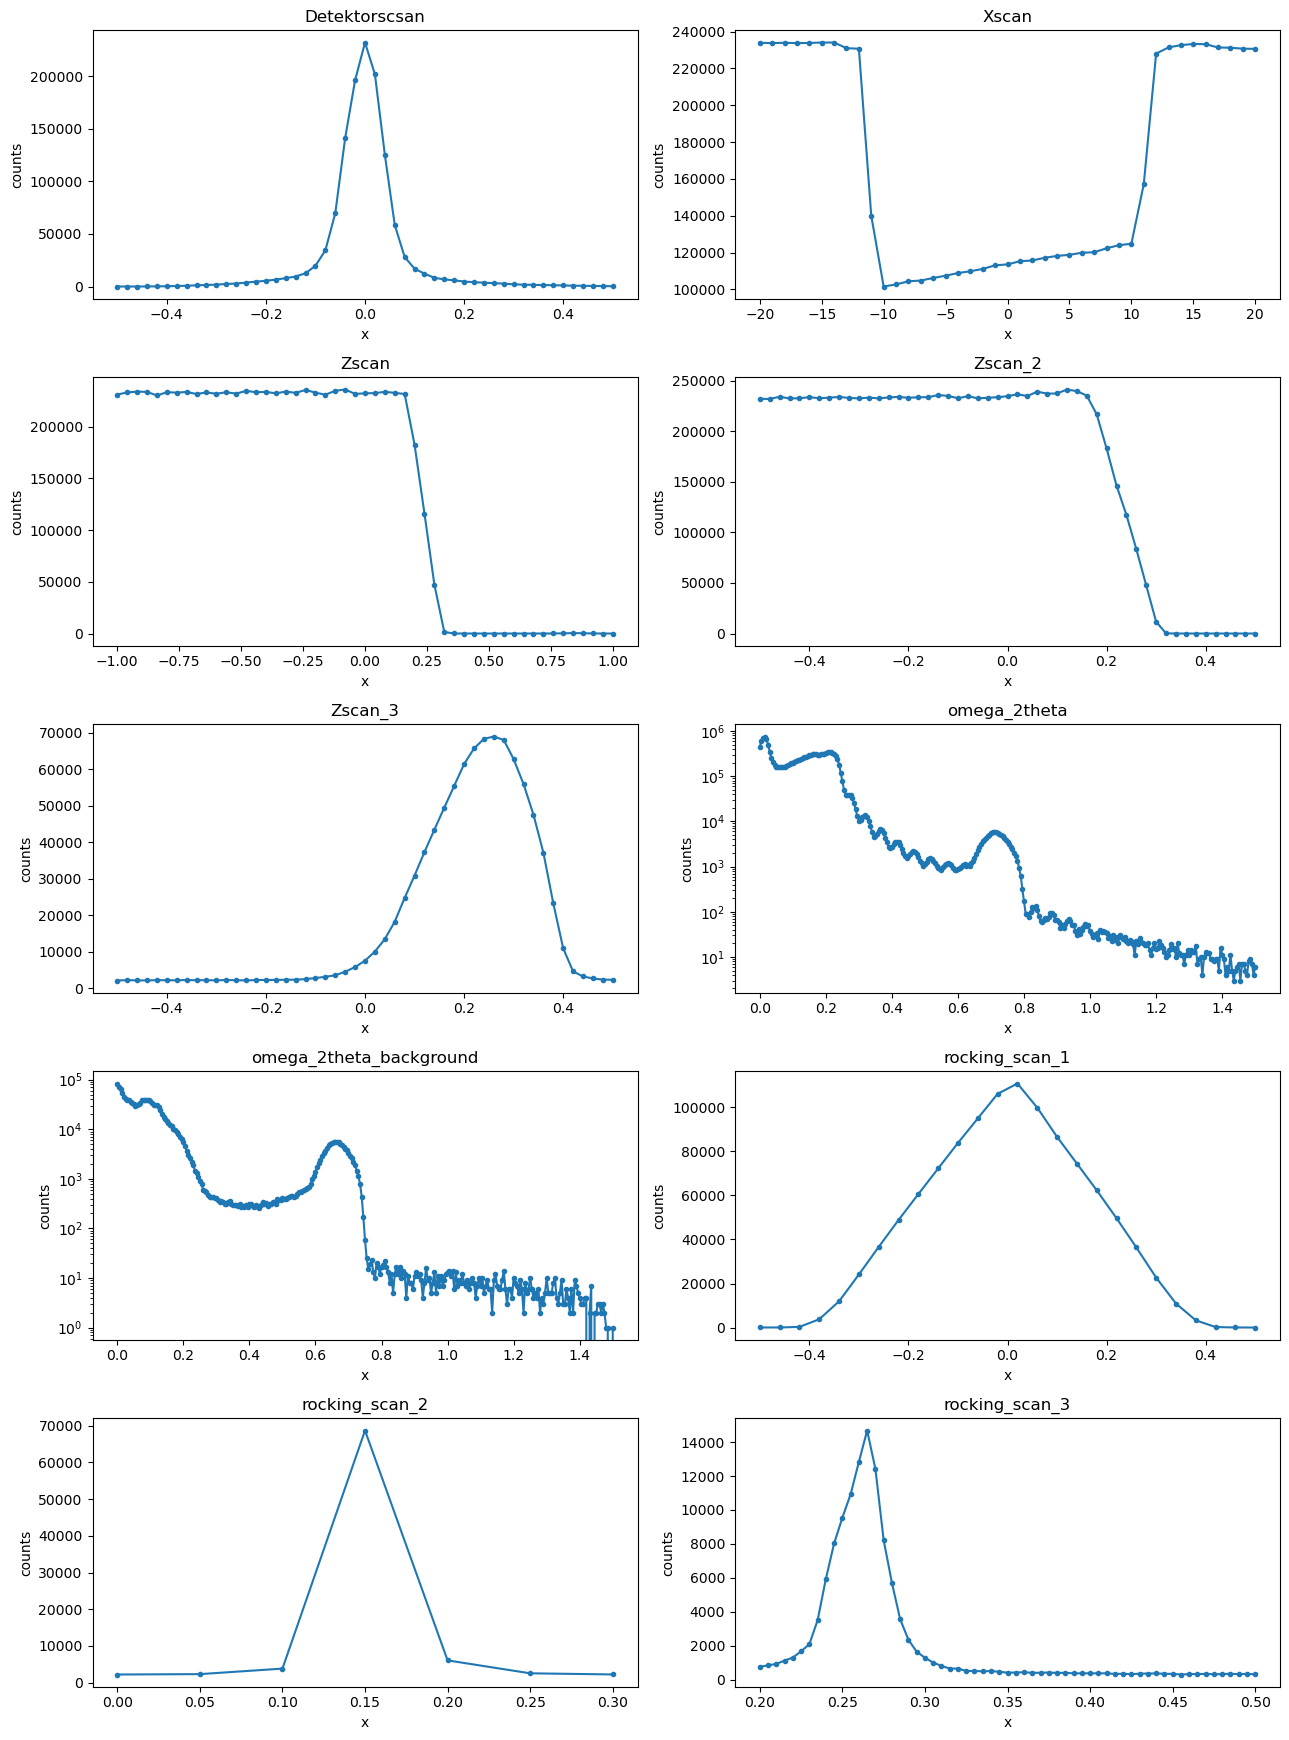

In [5]:
fig = plot_all_scans_tiled(all_scans, max_cols=2)
plt.show()

In [6]:
meta_det = metas["Detektorscsan"]

for k in sorted(meta_det.keys()):
    if any(s in k.upper() for s in ["DRIVE", "TYPE", "UNIT", "STEP", "RANGE", "START", "STOP"]):
        print(f"{k} = {meta_det[k]}")


_DRIVE = 2THETA
_RANGE_WL = 1.540600
_START = -0.500000
_STEPMODE = C
_STEPSIZE = 0.020000
_STEPTIME = 0.999980
_TIMESTARTED = 2.000000
_WL_UNIT = A


Gauß Fit for Detektorscan

In [7]:
t_det = 1.0
df_det = df_det.copy()
df_det["rate"] = df_det["counts"] / t_det


<Axes: xlabel='x'>

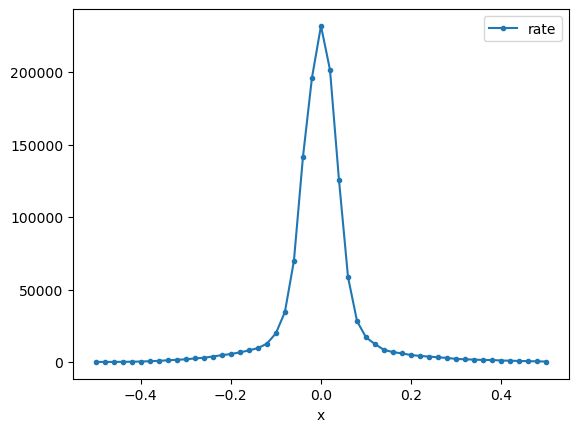

In [8]:
df_det.sort_values("x").plot(x="x", y="rate", style=".-")


<Axes: xlabel='x'>

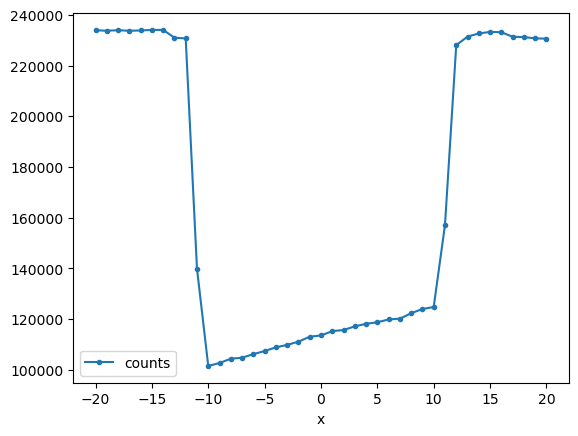

In [9]:
df_xscan = df_xscan.copy()
df_xscan.sort_values("x").plot(x="x", y="counts", style=".-")


I_top ≈ 232532.5, I_bottom ≈ 105516.5, I50 ≈ 169024.5
x_left  = -11.320 mm
x_right = 11.168 mm
D       = 22.489 mm


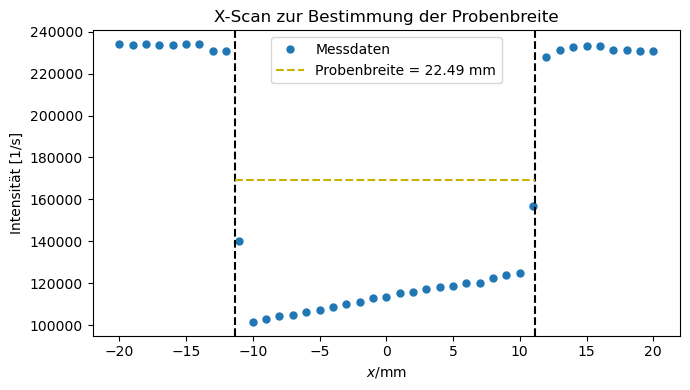

In [10]:
import numpy as np
import matplotlib.pyplot as plt

df = df_xscan.sort_values("x").copy()
x = df["x"].to_numpy(float)
I = df["counts"].to_numpy(float)   # oder df["rate"]

# 1) obere Plateaus (links & rechts): Median der ersten/letzten 10% Punkte
n = max(5, len(I)//10)
I_top_left  = np.median(I[:n])
I_top_right = np.median(I[-n:])
I_top = 0.5*(I_top_left + I_top_right)

# 2) "unten" im Tal: nimm die niedrigsten ~20% Punkte und median davon
k = max(5, len(I)//5)
I_bottom = np.median(np.sort(I)[:k])

# 3) 50%-Schwelle
I50 = I_bottom + 0.5*(I_top - I_bottom)

# 4) finde linke und rechte Flanke: Schwellenkreuzungen
# Wir suchen Indizes i, wo I[i]-I50 und I[i+1]-I50 unterschiedliche Vorzeichen haben.
cross = np.where((I[:-1] - I50) * (I[1:] - I50) <= 0)[0]

# Erwartung: zwei Kreuzungen (links und rechts)
if len(cross) < 2:
    raise RuntimeError("Zu wenige Schwellenkreuzungen gefunden. Prüfe I50 oder Datenbereich.")

# Nimm die äußersten beiden als linke und rechte Kante
iL = cross[0]
iR = cross[-1]

def x_at_threshold(i):
    x1, x2 = x[i], x[i+1]
    y1, y2 = I[i], I[i+1]
    return x1 + (I50 - y1) * (x2 - x1) / (y2 - y1)

xL = x_at_threshold(iL)
xR = x_at_threshold(iR)
D = xR - xL

print(f"I_top ≈ {I_top:.1f}, I_bottom ≈ {I_bottom:.1f}, I50 ≈ {I50:.1f}")
print(f"x_left  = {xL:.3f} mm")
print(f"x_right = {xR:.3f} mm")
print(f"D       = {D:.3f} mm")

# 5) Plot im Stil des Protokolls
plt.figure(figsize=(7,4))
plt.plot(x, I, "o", ms=5, label="Messdaten")

plt.axvline(xL, ls="--", c="k")
plt.axvline(xR, ls="--", c="k")
plt.hlines(I50, xL, xR, colors="#c9b100", linestyles="--", label=f"Probenbreite = {D:.2f} mm")

plt.xlabel(r"$x/\mathrm{mm}$")
plt.ylabel("Intensität [1/s]")
plt.title("X-Scan zur Bestimmung der Probenbreite")
plt.legend()
plt.tight_layout()
plt.savefig('plots/xscan.pdf')
plt.show()


<Axes: xlabel='x'>

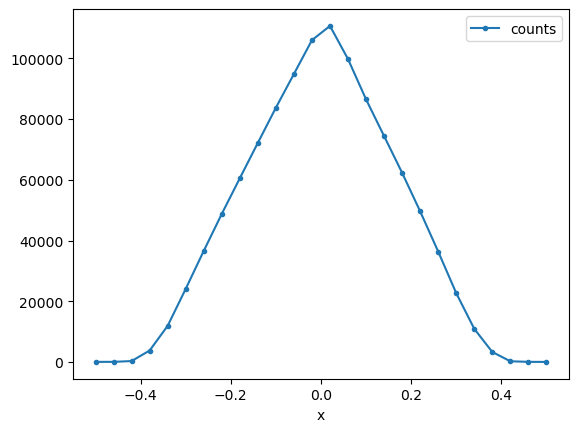

In [11]:
df_rock1.sort_values("x").plot(x=r"x", y="counts", style=".-")


I_bg = 281, sigma_bg = 4.63e+03, threshold = 2.59e+03 (k=0.5)
theta_L = -0.3937 deg
theta_R = 0.3893 deg
Geometriewinkel ≈ 0.3915 deg


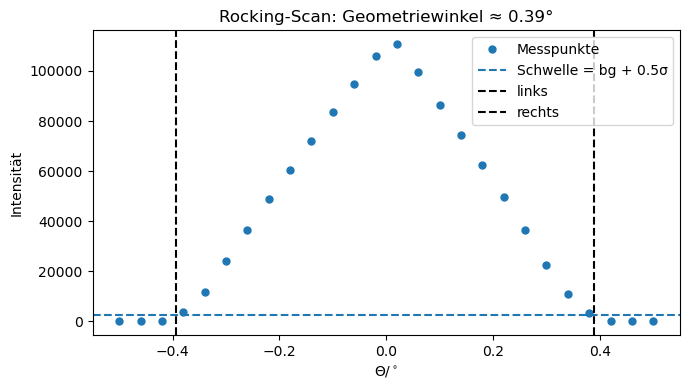

In [12]:
import numpy as np
import matplotlib.pyplot as plt

df = df_rock1.sort_values("x").copy()
theta = df["x"].to_numpy(float)      # deg
I = df["counts"].to_numpy(float)     # counts (oder rate)

# 1) "Null"-Untergrund aus den äußeren 10% Punkten
n = max(5, len(I)//10)
I_bg_samples = np.r_[I[:n], I[-n:]]
I_bg = np.median(I_bg_samples)
sig_bg = np.std(I_bg_samples, ddof=1)

# 2) Schwelle: "nicht mehr Null"
k = 0.5  
I_thr = I_bg + k*sig_bg

# 3) Indizes, wo Signal über Schwelle ist
above = np.where(I > I_thr)[0]
if len(above) < 2:
    raise RuntimeError("Schwelle wird nicht überschritten. k verkleinern oder Daten prüfen.")

iL = above[0]
iR = above[-1]

# 4) lineare Interpolation zu genauerem Kantenwinkel
def interp_theta(i1, i2):
    x1, x2 = theta[i1], theta[i2]
    y1, y2 = I[i1], I[i2]
    return x1 + (I_thr - y1)*(x2 - x1)/(y2 - y1)

theta_L = interp_theta(iL-1, iL) if iL > 0 else theta[iL]
theta_R = interp_theta(iR, iR+1) if iR < len(theta)-1 else theta[iR]

theta_g = 0.5*(abs(theta_L) + abs(theta_R))

print(f"I_bg = {I_bg:.3g}, sigma_bg = {sig_bg:.3g}, threshold = {I_thr:.3g} (k={k})")
print(f"theta_L = {theta_L:.4f} deg")
print(f"theta_R = {theta_R:.4f} deg")
print(f"Geometriewinkel ≈ {theta_g:.4f} deg")

# 5) Plot (wie im Protokoll, aber einfach)
plt.figure(figsize=(7,4))
plt.plot(theta, I, "o", ms=5, label="Messpunkte")
plt.axhline(I_thr, ls="--", label=f"Schwelle = bg + {k}σ")
plt.axvline(theta_L, ls="--", c="k", label="links")
plt.axvline(theta_R, ls="--", c="k", label="rechts")
plt.xlabel(r"$\Theta/^\circ$")
plt.ylabel("Intensität")
plt.title(f"Rocking-Scan: Geometriewinkel ≈ {theta_g:.2f}°")
plt.legend()
plt.tight_layout()
plt.savefig('plots/rscan.pdf')
plt.show()


In [13]:

df_det_s = df_det.sort_values("x")

x = df_det_s["x"].to_numpy()
y = df_det_s["rate"].to_numpy()

In [14]:
def gaussian(x, A, mu, sigma, c):
    return A * np.exp(-0.5 * ((x - mu) / sigma)**2) + c


In [15]:
A0 = y.max() - y.min()
mu0 = x[np.argmax(y)]
sigma0 = 0.05      # degrees (typical for D8 detector scan)
c0 = y.min()

p0 = [A0, mu0, sigma0, c0]


In [16]:
popt, pcov = curve_fit(
    gaussian,
    x,
    y,
    p0=p0
)

A, mu, sigma, c = popt
perr = np.sqrt(np.diag(pcov))


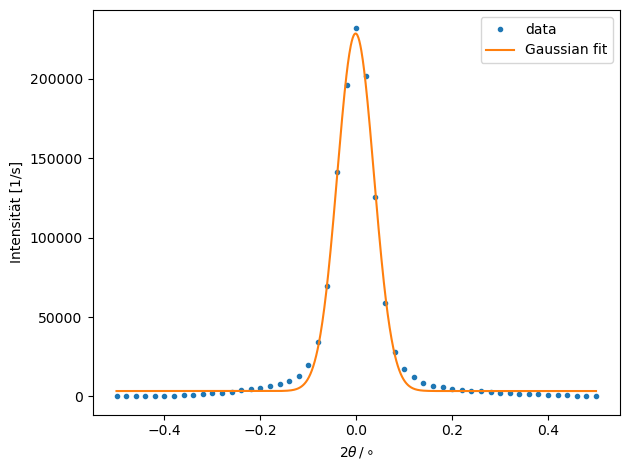

In [17]:
x_dense = np.linspace(x.min(), x.max(), 1000)

plt.figure()
plt.plot(x, y, ".", label="data")
plt.plot(x_dense, gaussian(x_dense, *popt), "-", label="Gaussian fit")
plt.xlabel(r"$2\theta\,/\circ$")
plt.ylabel("Intensität [1/s]")
plt.legend()
plt.tight_layout()
plt.savefig('plots/dscan.pdf')
plt.show()

In [18]:
I_max = A + c
FWHM = 2 * np.sqrt(2 * np.log(2)) * sigma


In [19]:
print(f"I_max  = {I_max:.0f} rate")
print(f"mu     = {mu:.4f} ± {perr[1]:.4f} deg")
print(f"sigma  = {sigma:.4f} ± {perr[2]:.4f} deg")
print(f"FWHM   = {FWHM:.4f} deg")


I_max  = 228603 rate
mu     = -0.0014 ± 0.0005 deg
sigma  = 0.0382 ± 0.0005 deg
FWHM   = 0.0900 deg


In [20]:
print(df_det["rate"].max())
(df_refl["counts"] / 5.0).max()


231826.0


151160.6

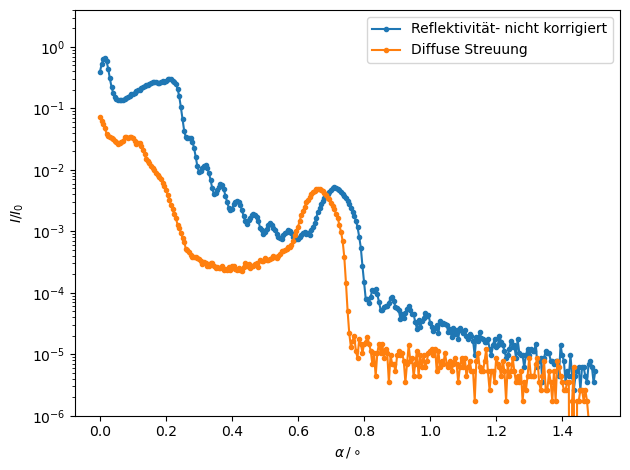

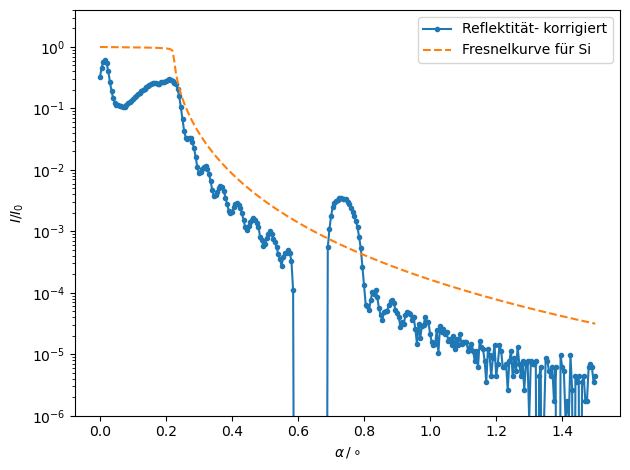

I0_rate (counts/s) = 228603.0
max(R_spec_raw) = 0.6612362917372038
max(R_sub)      = 0.6132290477377812


In [21]:
import numpy as np
import matplotlib.pyplot as plt

# ---- inputs you already have ----
I_max_counts = 228603  # from your Gaussian detector fit peak (A + c) in COUNTS

# steptimes from metadata (you said: detector scan 1 s, reflectivity 5 s, background 5 s)
t_det  = 1.0  # s
t_refl = 5.0  # s
t_bg   = 5.0  # s

# direct-beam reference as a RATE (counts/s)
I0_rate = I_max_counts / t_det

# wavelength for Cu Kα (use your metadata if available)
lambda_A = float(metas[list(metas.keys())[0]].get("_WL1", 1.5406))  # fallback 1.5406 Å
# Better (if you know the right key):
# lambda_A = float(metas["omega_2theta"].get("_WL1", 1.5406))

# ---- Fresnel reflectivity for vacuum -> Si (grazing-incidence stable form) ----
def fresnel_reflectivity(alpha_deg, wavelength_A, delta, beta):
    """
    Fresnel reflectivity R_F for vacuum -> medium n = 1 - delta + i beta
    at grazing incidence. alpha in deg, wavelength in Å. Returns dimensionless R.
    """
    alpha = np.deg2rad(alpha_deg)
    k = 2*np.pi / wavelength_A

    kz1 = k * np.sin(alpha)
    kz2 = k * np.sqrt(np.sin(alpha)**2 - 2*delta + 2j*beta)

    r = (kz1 - kz2) / (kz1 + kz2)
    return np.abs(r)**2

# Typical Si values at Cu Kα (good starting point)
delta_si = 7.6e-6
beta_si  = 1.0e-7

# ---- Prepare specular and diffuse scans ----
df_spec = df_refl.sort_values("x").copy()
df_diff = df_refl_bg.sort_values("x").copy()

# convert counts -> rates (counts/s) using the scan steptimes
df_spec["rate"] = df_spec["counts"] / t_refl
df_diff["rate"] = df_diff["counts"] / t_bg

alpha_spec = df_spec["x"].to_numpy()
I_spec_rate = df_spec["rate"].to_numpy()

alpha_diff = df_diff["x"].to_numpy()
I_diff_rate = df_diff["rate"].to_numpy()

# ---- Normalize measured data by direct-beam rate ----
R_spec_raw = I_spec_rate / I0_rate
R_diff_raw = I_diff_rate / I0_rate

# ---- Interpolate diffuse onto specular grid and subtract ----
R_diff_on_spec = np.interp(alpha_spec, alpha_diff, R_diff_raw)
R_sub = np.clip(R_spec_raw - R_diff_on_spec, 0.0, None)

# ---- Fresnel reflectivity (ideal smooth Si) on same alpha grid ----
R_fresnel_si = fresnel_reflectivity(alpha_spec, lambda_A, delta_si, beta_si)

# ---- Plot 1: measured specular and diffuse (rate-normalized) ----
plt.figure()
plt.semilogy(alpha_spec, np.clip(R_spec_raw, 1e-12, None), ".-", label="Reflektivität- nicht korrigiert")
plt.semilogy(alpha_diff, np.clip(R_diff_raw, 1e-12, None), ".-", label="Diffuse Streuung")
plt.xlabel(r"$\alpha\,/\circ$")
plt.ylabel(r"$I/I_0$")
plt.ylim(1e-6, 4)
plt.legend()
plt.tight_layout()
plt.savefig('plots/ref_raw.pdf')
plt.show()

# ---- Plot 2: background-subtracted + Fresnel Si ----
plt.figure()
plt.semilogy(alpha_spec, np.clip(R_sub, 1e-12, None), ".-", label="Reflektität- korrigiert")
plt.semilogy(alpha_spec, np.clip(R_fresnel_si, 1e-12, None), "--", label="Fresnelkurve für Si")
plt.xlabel(r"$\alpha\,/\circ$")
plt.ylabel(r"$I/I_0$")
plt.ylim(1e-6, 4)
plt.legend()
plt.tight_layout()
plt.savefig('plots/ref_mod.pdf')
plt.show()

# ---- Quick sanity prints ----
print("I0_rate (counts/s) =", I0_rate)
print("max(R_spec_raw) =", float(np.nanmax(R_spec_raw)))
print("max(R_sub)      =", float(np.nanmax(R_sub)))


In [22]:
print(alpha_spec.min(), alpha_spec.max())
print(alpha_diff.min(), alpha_diff.max())


0.0 1.5
0.0 1.5


In [23]:
print("max(counts in spec scan) =", df_spec["counts"].max())
print("I_max from detector fit  =", I_max)
print("ratio max/I_max =", df_spec["counts"].max()/I_max)


max(counts in spec scan) = 755803.0
I_max from detector fit  = 228602.9337007562
ratio max/I_max = 3.3061824175421766


In [24]:
spec_max_rate = df_spec["counts"].max() / t_refl
I0_rate       = I_max / t_det  # I_max is peak counts from detector scan

print("max spec rate (counts/s) =", spec_max_rate)
print("I0 rate from detector (counts/s) =", I0_rate)
print("ratio max_rate/I0_rate =", spec_max_rate / I0_rate)


max spec rate (counts/s) = 151160.6
I0 rate from detector (counts/s) = 228602.9337007562
ratio max_rate/I0_rate = 0.6612364835084353


In [25]:
alpha = df_spec["x"].to_numpy()
spec_rate = df_spec["counts"].to_numpy() / t_refl
diff_rate = np.interp(alpha, df_diff["x"].to_numpy(), df_diff["counts"].to_numpy() / t_bg)

R_sub_rate_norm = (spec_rate - diff_rate) / I0_rate

m = (alpha > 0.05) & (alpha < 0.15)  # adjust if needed
print("mean R_sub in [0.05,0.15] deg =", np.mean(R_sub_rate_norm[m]))
print("max  R_sub in [0.05,0.15] deg =", np.max(R_sub_rate_norm[m]))


mean R_sub in [0.05,0.15] deg = 0.15243862021075372
max  R_sub in [0.05,0.15] deg = 0.23085967946974525


In [26]:
def estimate_d0_from_zscan(df_z, xcol="x", ycol="counts", low=0.1, high=0.9):
    """
    Estimate beam height d0 from a Z-scan step curve:
    d0 ~ z(high) - z(low) using normalized intensity.
    Returns d0 in the same units as xcol (typically mm).
    """
    df = df_z.sort_values(xcol)
    z = df[xcol].to_numpy()
    I = df[ycol].to_numpy()

    # robust plateaus
    n = max(5, len(I)//10)
    I_top = np.median(I[:n])       # full beam
    I_bottom = np.median(I[-n:])   # blocked beam

    In = (I - I_bottom) / (I_top - I_bottom)  # normalize to ~1 ... 0

    # make interpolation monotonic
    if In[0] > In[-1]:  # decreasing
        In_use = In[::-1]
        z_use = z[::-1]
    else:
        In_use = In
        z_use = z

    z_low  = np.interp(low,  In_use, z_use)
    z_high = np.interp(high, In_use, z_use)

    d0 = abs(z_high - z_low)
    return float(d0), {"I_top": float(I_top), "I_bottom": float(I_bottom),
                       "z_low": float(z_low), "z_high": float(z_high)}

d0_est, info = estimate_d0_from_zscan(df_zscan)  # or df_zscan2
print("d0_est =", d0_est, " (units of Z-scan x)")
print(info)


d0_est = 0.12312938487936048  (units of Z-scan x)
{'I_top': 233240.0, 'I_bottom': 54.0, 'z_low': 0.30091644533461054, 'z_high': 0.17778706045525006}


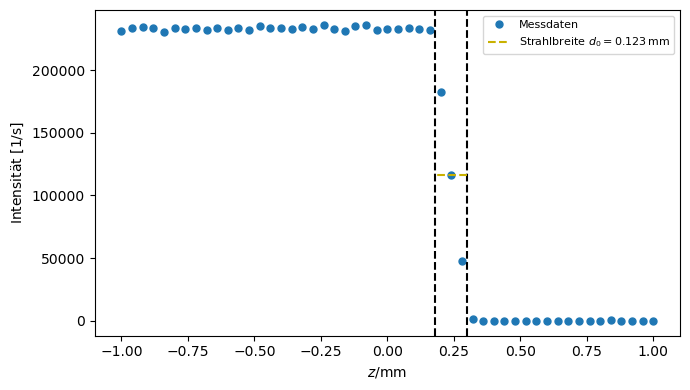

In [27]:
import numpy as np
import matplotlib.pyplot as plt

d0_est, info = estimate_d0_from_zscan(df_zscan)
z_low  = info["z_low"]
z_high = info["z_high"]
I_top  = info["I_top"]
I_bottom = info["I_bottom"]

df = df_zscan.sort_values("x")
z = df["x"].to_numpy(float)
I = df["counts"].to_numpy(float)

# falls du auf Rate willst:
# I = I / t_zscan

I10 = I_bottom + 0.1*(I_top - I_bottom)
I90 = I_bottom + 0.9*(I_top - I_bottom)

plt.figure(figsize=(7,4))
plt.plot(z, I, "o", ms=5, label="Messdaten")

plt.axvline(z_low,  ls="--", c="k")
plt.axvline(z_high, ls="--", c="k")

# plt.axhline(I10, ls="--", alpha=0.7, label="10% Niveau")
# plt.axhline(I90, ls="--", alpha=0.7, label="90% Niveau")

# gelbe Linie auf einem sinnvollen y-Level (z.B. in der Mitte zwischen I10 und I90)
plt.hlines(0.5*(I10+I90), z_low, z_high, colors="#c9b100", linestyles="--",
           label=fr"Strahlbreite $d_0 = {d0_est:.3f}\,\mathrm{{mm}}$")

plt.xlabel(r"$z/\mathrm{mm}$")
plt.ylabel(r"Intensität $[1/\mathrm{s}]$")
plt.legend(fontsize=8)
plt.tight_layout()
plt.savefig('plots/zscan.pdf')
plt.show()


In [28]:
df = df_zscan.sort_values("x")
print(df["x"].min(), df["x"].max())


-1.0 1.0


In [29]:
D_mm = 20
d0_mm = d0_est  # assuming Z is in mm; your value is plausible

alpha_g_rad = np.arcsin(d0_mm / D_mm)
alpha_g_deg = np.rad2deg(alpha_g_rad)

alpha_g_deg 

0.3527419326828588

In [30]:
def geometry_factor(alpha_deg, D_mm, d0_mm):
    a = np.deg2rad(alpha_deg)
    a_g = np.arcsin(d0_mm / D_mm)

    G = np.ones_like(a)
    m = a < a_g
    G[m] = (D_mm * np.sin(a[m])) / d0_mm

    # avoid division by zero at alpha ~ 0
    return np.clip(G, 1e-8, None), np.rad2deg(a_g)


In [31]:
I_max = 228603

# sort
df_spec = df_refl.sort_values("x")
df_diff = df_refl_bg.sort_values("x")

alpha = df_spec["x"].to_numpy()
R_spec = df_spec["counts"].to_numpy() / (I_max*5)

alpha_d = df_diff["x"].to_numpy()
R_diff = df_diff["counts"].to_numpy() / (I_max*5)

# interpolate diffuse onto specular grid and subtract
R_diff_i = np.interp(alpha, alpha_d, R_diff)
R_sub = R_spec - R_diff_i

# geometry factor and correction
G, alpha_g_deg = geometry_factor(alpha, D_mm=20.0, d0_mm=d0_est)
R_corr = R_sub / G

print(f"alpha_g (from d0/D) = {alpha_g_deg:.4f} deg")

alpha_g (from d0/D) = 0.3527 deg


In [32]:
print("alpha_g_deg =", alpha_g_deg)

# values at the very first few points
for i in range(5):
    print(i, alpha[i], R_spec[i], R_diff_i[i], R_sub[i], G[i], R_corr[i])

print("max R_spec =", np.nanmax(R_spec))
print("max R_sub  =", np.nanmax(R_sub))
print("max R_corr =", np.nanmax(R_corr))


alpha_g_deg = 0.3527419326828588
0 0.0 0.3936763734509171 0.07319676469687625 0.32047960875404086 1e-08 32047960.875404086
1 0.005 0.5267472430370556 0.06324413940324493 0.46350310363381064 0.014174758133398663 32.69918959263943
2 0.01 0.6289934952734654 0.056062256400834634 0.5729312388726308 0.02834951615885037 20.209559685686866
3 0.015 0.6612362917372038 0.04800724399942258 0.6132290477377812 0.042524273968408154 14.420682365873128
4 0.02 0.5861235416858046 0.038568172771135986 0.5475553689146686 0.05669903145412509 9.657226144289483
max R_spec = 0.6612362917372038
max R_sub  = 0.6132290477377812
max R_corr = 32047960.875404086


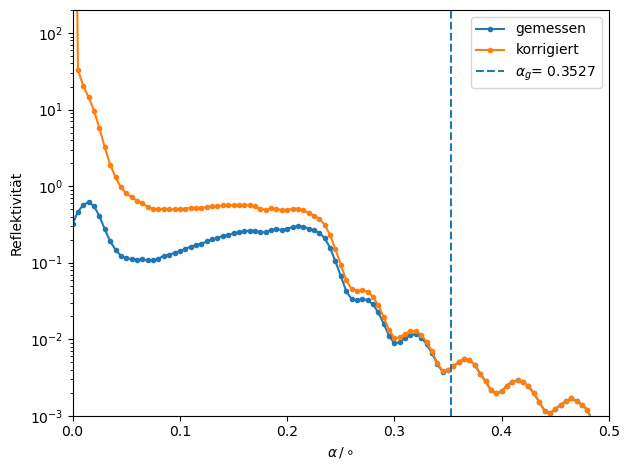

In [33]:
plt.figure()
plt.semilogy(alpha, np.clip(R_sub, 1e-12, None), ".-", label="gemessen")
plt.semilogy(alpha, np.clip(R_corr, 1e-12, None), ".-", label="korrigiert")
plt.axvline(alpha_g_deg, linestyle="--", label=rf"$\alpha_g$= {alpha_g_deg:.4f}")
plt.xlabel(r"$\alpha\,/\circ$")
plt.ylabel("Reflektivität")
plt.ylim(1e-3, 200)
plt.xlim(0,0.5)
plt.legend()
plt.tight_layout()
plt.savefig('plots/g_corr.pdf')

plt.show()


In [34]:
ratio = np.where(R_sub > 0, R_corr / R_sub, np.nan)

# find first angle where ratio is close to 1 within 2% and stays there
tol = 0.002
m = np.isfinite(ratio) & (np.abs(ratio - 1.0) < tol)

alpha_g_meas = np.nan
if np.any(m):
    alpha_g_meas = alpha[m][0]

print("alpha_g_meas ~", alpha_g_meas)
print("alpha_g_calc =", alpha_g_deg)

alpha_g_meas ~ 0.355
alpha_g_calc = 0.3527419326828588


/tmp/ipykernel_4430/2987303247.py:1: RuntimeWarning: invalid value encountered in divide
  ratio = np.where(R_sub > 0, R_corr / R_sub, np.nan)


In [35]:
# wavelength (Å)
lambda_A = float(metas[list(metas.keys())[0]].get("_WL1", 1.5406))

# qz in 1/Å
qz = (4 * np.pi / lambda_A) * np.sin(np.deg2rad(alpha))
mask = (alpha > 0.3) & (alpha < 0.60) & np.isfinite(R_corr) & (R_corr > 0)

qz_sel = qz[mask]
R_sel  = R_corr[mask]


In [36]:
from scipy.signal import find_peaks
from uncertainties import ufloat

# use log to make oscillations more uniform
y = np.log(R_sel)

# find peaks (tune prominence if needed)
peaks, props = find_peaks(y, prominence=0.2, distance=3)

qz_peaks = qz_sel[peaks]

# spacings Δqz between consecutive peaks
dq = np.diff(qz_peaks)

dq_mean = np.mean(dq)
dq_std  = np.std(dq, ddof=1) if len(dq) > 1 else np.nan
dq = ufloat(dq_mean, dq_std)   

# thickness estimate in Å then nm
d_A  = 2*np.pi / dq
d_nm = d_A * 0.1

print("Number of peaks used:", len(qz_peaks))
print(f"Δqz = {dq:.4f}")
print(f"Thickness d = {d_nm:.2f}")


Number of peaks used: 6
Δqz = 0.0071+/-0.0005
Thickness d = 88.27+/-6.24


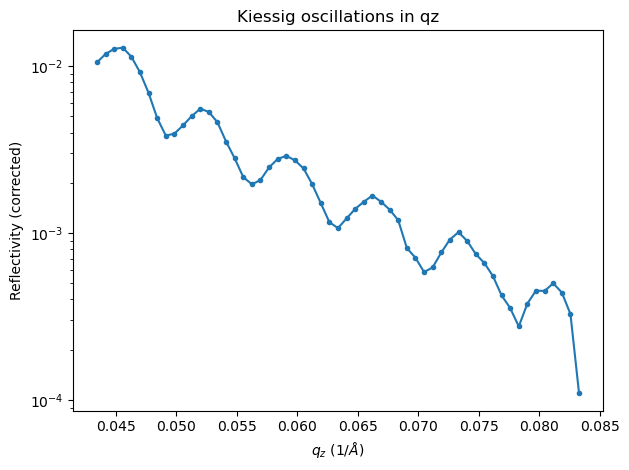

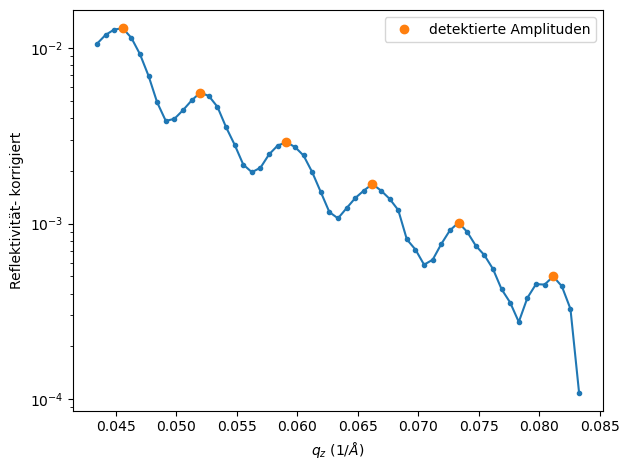

In [37]:
plt.figure()
plt.semilogy(qz_sel, R_sel, ".-")
plt.xlabel(r"$q_z$ (1/$\AA$)")
plt.ylabel("Reflectivity (corrected)")
plt.title("Kiessig oscillations in qz")
plt.tight_layout()
plt.show()

# mark peaks (method A)
plt.figure()
plt.semilogy(qz_sel, R_sel, ".-")
plt.semilogy(qz_peaks, R_sel[peaks], "o", label="detektierte Amplituden")
plt.xlabel(r"$q_z$ (1/$\AA$)")
plt.ylabel("Reflektivität- korrigiert")
plt.legend()
plt.tight_layout()
plt.savefig('plots/kiessig.pdf')

plt.show()


Detected critical-angle candidates (deg): []

Literature:
PS: alpha_c = 0.153 deg, delta = 3.50e-06
Si: alpha_c = 0.174 deg, delta = 7.60e-06


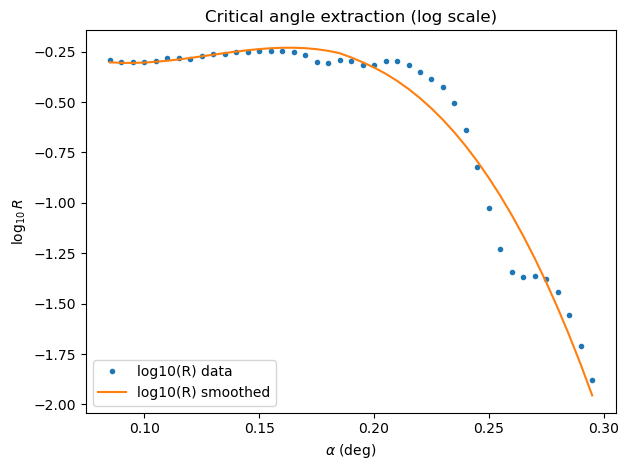

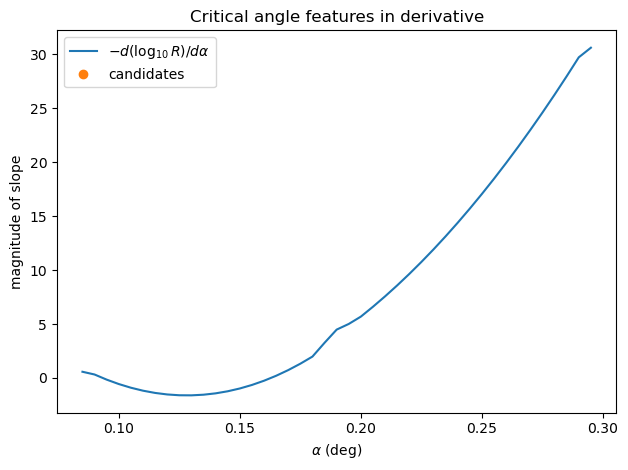

In [38]:
from scipy.signal import savgol_filter, find_peaks

# ---- Literature values (given) ----
lit = {
    "Si": {"delta": 7.6e-6, "alpha_c_deg": 0.174},
    "PS": {"delta": 3.5e-6, "alpha_c_deg": 0.153},
}

# ---- Select a sensible angle window for critical-angle detection ----
# You can adjust this if needed; it should bracket both critical angles.
mask = (alpha > 0.08) & (alpha < 0.30) & np.isfinite(R_corr) & (R_corr > 0)

a = alpha[mask]
R = R_corr[mask]

# Work in log space
y = np.log10(R)

# Smooth logR to suppress noise but keep the step
# window_length must be odd and < len(y)
window_length = min(len(y)//2*2-1, 41)  # up to 41 points, odd
window_length = max(window_length, 11)  # at least 11
polyorder = 3

y_s = savgol_filter(y, window_length=window_length, polyorder=polyorder)

# Derivative d(logR)/dα
dy_da = np.gradient(y_s, a)

# The critical-angle drop corresponds to the most negative slope
# Find peaks in (-dy/da)
peaks, props = find_peaks(-dy_da, prominence=0.2)

a_peaks = a[peaks]
prom = props["prominences"]

# Sort candidate features by prominence (most pronounced first)
order = np.argsort(prom)[::-1]
a_peaks = a_peaks[order]

# Keep up to two critical angles (film + substrate), ordered low->high
# If your data clearly shows only one, you'll get one.
a_cs = np.sort(a_peaks[:2])

print("Detected critical-angle candidates (deg):", a_cs)

# Convert αc -> δ using δ = αc^2 / 2  (αc in radians)
def delta_from_alpha_c(alpha_c_deg):
    ac = np.deg2rad(alpha_c_deg)
    return 0.5 * ac**2

results = []
labels = ["PS (film)", "Si (substrate)"]  # expected order low->high

for i, ac_deg in enumerate(a_cs):
    d_meas = delta_from_alpha_c(ac_deg)
    results.append((labels[i] if i < 2 else f"alpha_c_{i}", ac_deg, d_meas))

# Print comparison
for name, ac_deg, d_meas in results:
    print(f"{name:14s}: alpha_c = {ac_deg:.4f} deg  ->  delta = {d_meas:.3e}")

print("\nLiterature:")
print(f"PS: alpha_c = {lit['PS']['alpha_c_deg']:.3f} deg, delta = {lit['PS']['delta']:.2e}")
print(f"Si: alpha_c = {lit['Si']['alpha_c_deg']:.3f} deg, delta = {lit['Si']['delta']:.2e}")

# ---- Diagnostic plot (strongly recommended) ----
plt.figure()
plt.plot(a, y, ".", label="log10(R) data")
plt.plot(a, y_s, "-", label="log10(R) smoothed")
for ac in a_cs:
    plt.axvline(ac, linestyle="--", label=rf"$\alpha_c={ac:.4f}^\circ$")
plt.xlabel(r"$\alpha$ (deg)")
plt.ylabel(r"$\log_{10} R$")
plt.title("Critical angle extraction (log scale)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(a, -dy_da, "-", label=r"$-d(\log_{10}R)/d\alpha$")
plt.plot(a[peaks], (-dy_da)[peaks], "o", label="candidates")
for ac in a_cs:
    plt.axvline(ac, linestyle="--")
plt.xlabel(r"$\alpha$ (deg)")
plt.ylabel(r"magnitude of slope")
plt.title("Critical angle features in derivative")
plt.legend()
plt.tight_layout()
plt.show()


In [39]:
lambda_A = float(metas[list(metas.keys())[0]].get("_WL1", 1.5406))

qz = (4*np.pi/lambda_A) * np.sin(np.deg2rad(alpha))  # 1/A
mask = (
    np.isfinite(R_corr)
    & (R_corr > 0)
    & (
        ((alpha > 0.10) & (alpha < 0.6)) |
        ((alpha >= 0.6) & (alpha <= 1.4))
      )
)
a_fit = alpha[mask]
R_fit = R_corr[mask]
qz_fit = qz[mask]

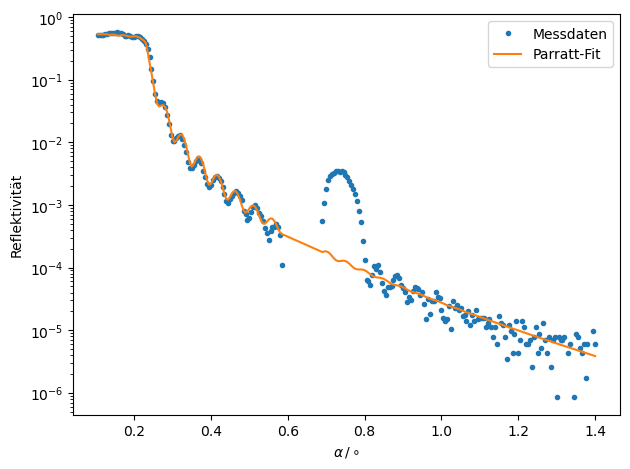

d = 90.40 nm
delta_f (film) = 2.110e-06
delta_s (Si)   = 7.600e-06  (fixed)
sigma01 (air/film) = 21.67 Å
sigma12 (film/Si)  = 5.41 Å
beta_f (film) = 3.813e-28
beta_s (Si)   = 1.900e-07  (fixed)
bg   = 1.000e-09  (fixed)
alpha0 = -0.0099 deg
S = 0.5313


In [40]:
from scipy.optimize import least_squares
import numpy as np
import matplotlib.pyplot as plt

def parratt_1film(alpha_deg, lambda_A, params):
    """
    params = (d_A, delta_f, beta_f, delta_s, beta_s, sigma01, sigma12, bg, alpha0_deg, logS)
    Lengths in Å, alpha in degrees, lambda in Å.
    """
    d_A, delta_f, beta_f, delta_s, beta_s, sigma01, sigma12, bg, alpha0_deg, logS = params

    # apply angle offset
    a = np.deg2rad(alpha_deg + alpha0_deg)
    k0 = 2*np.pi / lambda_A

    n0 = 1.0 + 0.0j
    n1 = (1.0 - delta_f) + 1j*beta_f
    n2 = (1.0 - delta_s) + 1j*beta_s

    kz0 = k0 * np.sqrt((n0**2 - np.cos(a)**2) + 0j)
    kz1 = k0 * np.sqrt((n1**2 - np.cos(a)**2) + 0j)
    kz2 = k0 * np.sqrt((n2**2 - np.cos(a)**2) + 0j)

    r01 = (kz0 - kz1) / (kz0 + kz1)
    r12 = (kz1 - kz2) / (kz1 + kz2)

    # Nevot–Croce
    r01 *= np.exp(-2 * kz0 * kz1 * sigma01**2)
    r12 *= np.exp(-2 * kz1 * kz2 * sigma12**2)

    phase = np.exp(2j * kz1 * d_A)

    R2 = 0.0 + 0.0j
    R1 = (r12 + R2 * phase) / (1 + r12 * R2 * phase)
    R0 = (r01 + R1 * phase) / (1 + r01 * R1 * phase)

    R = np.abs(R0)**2

    S = np.exp(logS)   # ensures S > 0
    return S * R + bg


def make_residuals_log10(alpha_deg, R_meas, lambda_A,
                         delta_s_fixed, beta_s_fixed, bg_fixed):
    """
    Fit parameters:
      p_fit = (d_A, delta_f, beta_f, sigma01, sigma12, alpha0_deg, logS)
    Fixed:
      delta_s, beta_s, bg
    """
    R_meas = np.asarray(R_meas)

    def residuals(p_fit):
        d_A, delta_f, beta_f, sigma01, sigma12, alpha0_deg, logS = p_fit
        p_full = (d_A, delta_f, beta_f,
                  delta_s_fixed, beta_s_fixed,
                  sigma01, sigma12,
                  bg_fixed, alpha0_deg, logS)

        Rm = parratt_1film(alpha_deg, lambda_A, p_full)

        if not np.all(np.isfinite(Rm)):
            return np.ones_like(R_meas) * 1e6

        Rm = np.clip(Rm, 1e-14, None)
        Rm_meas = np.clip(R_meas, 1e-14, None)
        return np.log10(Rm) - np.log10(Rm_meas)

    return residuals


# ---- Fixed constants ----
delta_s_fixed = 7.6e-6
beta_s_fixed  = 1.9e-7
bg_fixed      = 1e-9   # keep fixed as requested

# ---- Initial guesses ----
d_nm_guess = 88.6
d_A_guess = d_nm_guess * 10.0

p0_fit = np.array([
    d_A_guess,  # d_A (Å)
    1.6e-6,     # delta_f
    1.7e-8,     # beta_f
    16.0,       # sigma01 (Å)
    9.6,       # sigma12 (Å)
    0.0,        # alpha0_deg
    0.0         # logS (S=1)
], dtype=float)

# ---- Bounds ----
lb_fit = np.array([
    700.0,    # d_A
    1e-6,    # delta_f
    0.0,     # beta_f
    0.5,     # sigma01
    0.5,     # sigma12
    -0.05,   # alpha0_deg (allow up to 0.05° offset)
    np.log(0.2)   # logS
], dtype=float)

ub_fit = np.array([
    1000.0,  # d_A
    6e-6,    # delta_f
    1.8e-7,    # beta_f
    30.0,    # sigma01
    30.0,    # sigma12
    +0.05,   # alpha0_deg
    np.log(5.0)   # logS
], dtype=float)

# ---- Fit ----
residual_fun = make_residuals_log10(a_fit, R_fit, lambda_A,
                                    delta_s_fixed, beta_s_fixed, bg_fixed)

res = least_squares(
    residual_fun,
    p0_fit,
    bounds=(lb_fit, ub_fit),
    loss="soft_l1",
    f_scale=0.05,
    x_scale="jac"
)

popt_fit = res.x
d_A, delta_f, beta_f, sigma01, sigma12, alpha0_deg, logS = popt_fit
S = np.exp(logS)

# reconstruct full params for evaluation
popt_full = np.array([d_A, delta_f, beta_f, delta_s_fixed, beta_s_fixed,
                      sigma01, sigma12, bg_fixed, alpha0_deg, logS], dtype=float)

R_model = parratt_1film(a_fit, lambda_A, popt_full)

# ---- Plot ----
plt.figure()
plt.semilogy(a_fit, np.clip(R_fit, 1e-14, None), ".", label="Messdaten")
plt.semilogy(a_fit, np.clip(R_model, 1e-14, None), "-", label="Parratt-Fit")
plt.xlabel(r"$\alpha\,/\circ$")
plt.ylabel("Reflektivität")
plt.legend()
plt.tight_layout()
plt.savefig("plots/parratt.pdf")
plt.show()

# ---- Print ----
print(f"d = {d_A/10:.2f} nm")
print(f"delta_f (film) = {delta_f:.3e}")
print(f"delta_s (Si)   = {delta_s_fixed:.3e}  (fixed)")
print(f"sigma01 (air/film) = {sigma01:.2f} Å")
print(f"sigma12 (film/Si)  = {sigma12:.2f} Å")
print(f"beta_f (film) = {beta_f:.3e}")
print(f"beta_s (Si)   = {beta_s_fixed:.3e}  (fixed)")
print(f"bg   = {bg_fixed:.3e}  (fixed)")
print(f"alpha0 = {alpha0_deg:+.4f} deg")
print(f"S = {S:.4f}")
